In [ ]:
0# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

0

In [ ]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
# Add the swish function to Keras
import tensorflow as tf
from tensorflow.keras.activations import softplus, tanh, sigmoid, softplus, elu, selu, relu, softsign, hard_sigmoid
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sin
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import ThresholdedReLU


#learnable param
# beta=tf.Variable(0.1)
# def swish(x):
#     return x*tf.math.sigmoid(beta*x)
# get_custom_objects().update({'Swish':Activation(swish)})

from tensorflow.keras.activations import sigmoid, relu, tanh, softplus, selu, elu, softsign
def SoftClipping_Swish(x):
    return tf.maximum(0.0, swish(x))
get_custom_objects().update({'SC Swish':Activation(SoftClipping_Swish)})

def swish(x):
    return x*sigmoid(x)
get_custom_objects().update({'Swish':Activation(swish)})

act_func = ['sigmoid', 'tanh', 'relu', 'Swish', 'SC Swish']


In [ ]:
from tensorflow.keras.datasets import cifar100
# Load the CIFAR100 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [ ]:

# Training parameters
# batch_size = 32  # orig paper trained all networks with batch_size=128
batch_size = 128
epochs = 100
data_augmentation = False
num_classes = 100

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

def preprocess_cifar100(x_train, y_train, x_test, y_test):
    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, y_train, x_test, y_test, input_shape
    
x_train, y_train, x_test, y_test, input_shape = preprocess_cifar100(x_train, y_train, x_test, y_test)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-5
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
for activation in act_func:
    def resnet_layer(inputs,
                     num_filters=16,
                     kernel_size=3,
                     strides=1,
                     activation=activation,
                     batch_normalization=True,
                     conv_first=True):
        """2D Convolution-Batch Normalization-Activation stack builder

        # Arguments
            inputs (tensor): input tensor from input image or previous layer
            num_filters (int): Conv2D number of filters
            kernel_size (int): Conv2D square kernel dimensions
            strides (int): Conv2D square stride dimensions
            activation (string): activation name
            batch_normalization (bool): whether to include batch normalization
            conv_first (bool): conv-bn-activation (True) or
                bn-activation-conv (False)

        # Returns
            x (tensor): tensor as input to the next layer
        """
        conv = Conv2D(num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=l2(1e-4))

        x = inputs
        if conv_first:
            x = conv(x)
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
        else:
            if batch_normalization:
                x = BatchNormalization()(x)
            if activation is not None:
                x = Activation(activation)(x)
            x = conv(x)
        return x

In [ ]:
def resnet_v1(activation,input_shape, depth, num_classes=100):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x =tf.keras.layers.add([x, y])
            x = Activation(activation)(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

model = resnet_v1(activation=activation, input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
earlyStopping = EarlyStopping(monitor='val_acc', 
                              min_delta=0, 
                              patience=15, 
                              verbose=0, mode='max', 
                              baseline=None, 
                              restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=15,
                               min_lr=0.5e-6)
tb=TensorBoard(log_dir='./logs', 
               histogram_freq=0, 
               write_graph=True, 
               write_grads=False, 
               write_images=True, 
               embeddings_freq=0, 
               embeddings_layer_names=None,
               embeddings_metadata=None, embeddings_data=None, update_freq='epoch')


callbacks = [earlyStopping, checkpoint, lr_reducer, lr_scheduler, tb]

Learning rate:  1e-05
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation_2 (Activation)      (None, 32, 32, 16)   0           ['batch

In [ ]:
result = []
final_acc = []
final_loss = []
name=[]
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
    # model = model(activation=activation,
    #                           input_shape=input_shape,
    #                           depth=depth)
    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
        
        result.append(history)
        final_acc.append(history.history['val_accuracy'][-1])
        final_loss.append(history.history['val_loss'][-1])
        name.append(activation)
        
        print('{} \n val loss: {}, val acc: {}\n'.format(activation,history.history['val_loss'][-1], history.history['val_accuracy'][-1]))

    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        # datagen = ImageDataGenerator(
        #     # set input mean to 0 over the dataset
        #     featurewise_center=False,
        #     # set each sample mean to 0
        #     samplewise_center=False,
        #     # divide inputs by std of dataset
        #     featurewise_std_normalization=False,
        #     # divide each input by its std
        #     samplewise_std_normalization=False,
        #     # apply ZCA whitening
        #     zca_whitening=False,
        #     # epsilon for ZCA whitening
        #     zca_epsilon=1e-06,
        #     # randomly rotate images in the range (deg 0 to 180)
        #     rotation_range=0,
        #     # randomly shift images horizontally
        #     width_shift_range=0.1,
        #     # randomly shift images vertically
        #     height_shift_range=0.1,
        #     # set range for random shear
        #     shear_range=0.,
        #     # set range for random zoom
        #     zoom_range=0.,
        #     # set range for random channel shifts
        #     channel_shift_range=0.,
        #     # set mode for filling points outside the input boundaries
        #     fill_mode='nearest',
        #     # value used for fill_mode = "constant"
        #     cval=0.,
        #     # randomly flip images
        #     horizontal_flip=True,
        #     # randomly flip images
        #     vertical_flip=False,
        #     # set rescaling factor (applied before any other transformation)
        #     rescale=None,
        #     # set function that will be applied on each input
        #     preprocessing_function=None,
        #     # image data format, either "channels_first" or "channels_last"
        #     data_format=None,
        #     # fraction of images reserved for validation (strictly between 0 and 1)
        #     validation_split=0.0)

        # # Compute quantities required for featurewise normalization
        # # (std, mean, and principal components if ZCA whitening is applied).
        # history = datagen.fit(x_train)

        # # Fit the model on the batches generated by datagen.flow().
        # history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
        #                     validation_data=(x_test, y_test),
        #                     epochs=epochs, verbose=1, workers=4,
        #                     callbacks=callbacks)
        # result.append(history)
        # final_acc.append(history.history['val_accuracy'][-1])
        # final_loss.append(history.history['val_loss'][-1])
        # name.append(activation)
        
        # print('{} \n val loss: {}, val acc: {}\n'.format(activation,history.history['val_loss'][-1], history.history['val_accuracy'][-1]))

print(result)

# i=0


# a=0
# while(i<len(act_func)):
#     dict={name[i]: {final_acc[i], final_loss[i]}}
    
#     print(dict)
#     if i>0 and final_acc[i]>final_acc[i-1]:
#         a=final_acc[i]
#         nume=name[i]
#     i+=1
# print('Best acc made by function {} with acc of {}'.format(nume,a))

    


Training with -->sigmoid<-- activation function

Not using data augmentation.
Learning rate:  1e-05
Epoch 1/100
391/391 [==============================] - 26s 39ms/step - loss: 5.3069 - accuracy: 0.0118 - val_loss: 4.8450 - val_accuracy: 0.0128 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/100
391/391 [==============================] - 14s 36ms/step - loss: 4.9090 - accuracy: 0.0195 - val_loss: 4.8287 - val_accuracy: 0.0237 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 3/100
391/391 [==============================] - 14s 35ms/step - loss: 4.7828 - accuracy: 0.0221 - val_loss: 4.7530 - val_accuracy: 0.0260 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 4/100
391/391 [==============================] - 14s 36ms/step - loss: 4.7300 - accuracy: 0.0247 - val_loss: 4.7083 - val_accuracy: 0.0292 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 5/100
391/391 [==============================] - 14s 36ms/step - loss: 4.6974 - accuracy: 0.0281 - val_loss: 4.6779 - val_accuracy: 0.0303 - lr: 1.0000e-05
L

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

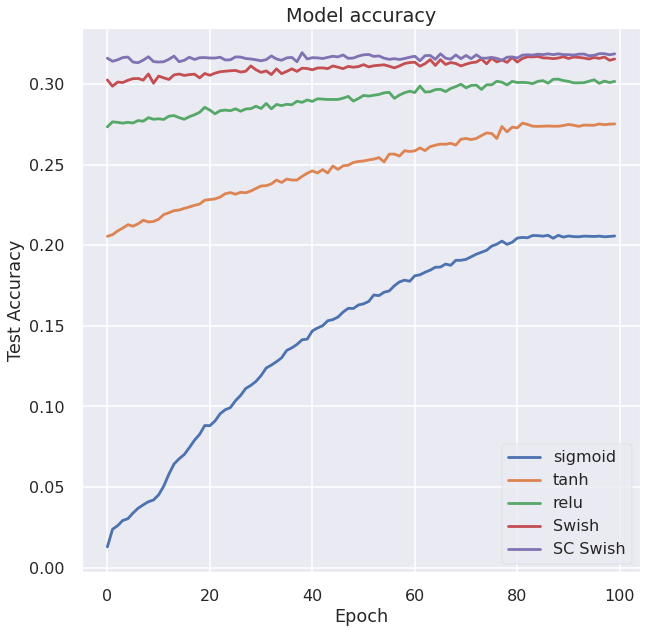

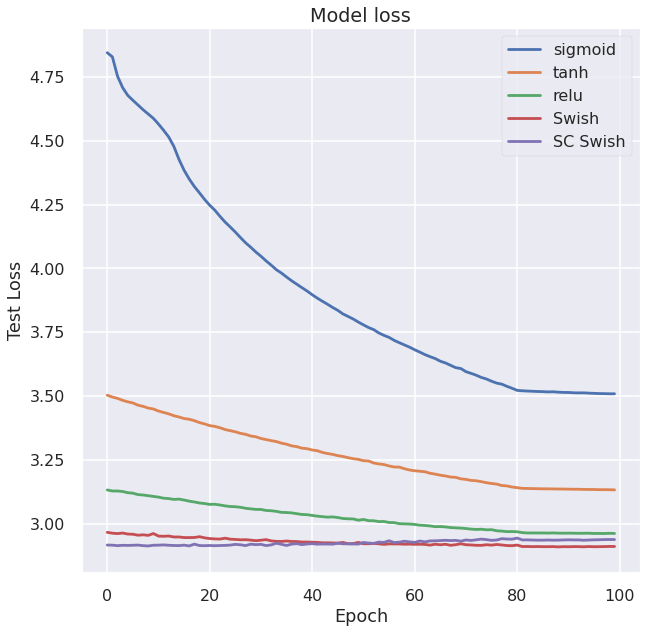

In [ ]:
import matplotlib.pyplot as plt
new_act_arr = act_func[0:]
new_results = result[0:]

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-poster')
    
    # Plot validation accuracy values
    for act_func in results:
        plt.plot(act_func.history['val_accuracy'])
        
    plt.title('Model accuracy')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

    # Plot validation loss values
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_loss'])
        
    plt.title('Model loss')
    plt.ylabel('Test Loss')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(new_results, new_act_arr)

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 3s 10ms/step - loss: 2.9381 - accuracy: 0.3187
Test loss: 2.9381353855133057
Test accuracy: 0.31869998574256897


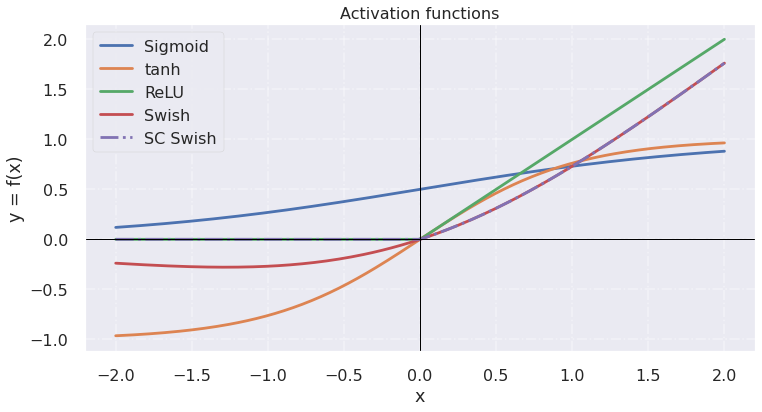

In [ ]:
import seaborn as sns
# sns.set_theme(style="darkgrid")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(x):
    return (np.exp(x)-np.exp(-x)) / (np.exp(x) + np.exp(-x))

def der_hyperb(x):
    return 1 - ((np.exp(x)-np.exp(-x)) / (np.exp(x) + np.exp(-x)))**2

import numpy as np
import matplotlib.pyplot as plt

# Data which will go through activations
x = np.linspace(-2,2,200)
plt.figure(figsize=(12,6))
plt.style.use('seaborn-poster')



plt.plot(x, sigmoid(x), label="Sigmoid")
plt.plot(x, tanh(x), label="tanh")
plt.plot(x, relu(x), label="ReLU")
plt.plot(x, swish(x), label="Swish")
plt.plot(x, SoftClipping_Swish(x), label="SC Swish", ls='-.')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.axhline(lw=1, c='black')
plt.axvline(lw=1, c='black')
plt.grid(alpha=0.4, ls='-.')
# plt.box(on=None)
plt.title("Activation functions", fontsize = 16)
plt.legend()
plt.show()